In [1]:
%matplotlib inline

=====================
NWS Precipitation Map
=====================

Plot a 1-day precipitation map using a netCDF file from the National Weather Service.

This opens the data directly in memory using the support in the netCDF library to open
from an existing memory buffer. In addition to CartoPy and Matplotlib, this uses
a custom colortable as well as MetPy's unit support.

Imports

In [2]:
from datetime import datetime, timedelta
from urllib.request import urlopen

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from metpy.units import masked_array, units
from netCDF4 import Dataset

Download the data from the National Weather Service.

In [3]:
dt = datetime.utcnow() - timedelta(days=1)  # This should always be available
url = 'http://water.weather.gov/precip/downloads/{dt:%Y/%m/%d}/nws_precip_1day_'\
      '{dt:%Y%m%d}_conus.nc'.format(dt=dt)
data = urlopen(url).read()
nc = Dataset('', memory=data)

Pull the needed information out of the netCDF file

In [4]:
prcpvar = nc.variables['observation']
data = masked_array(prcpvar[:], units(prcpvar.units.lower())).to('mm')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
proj_var = nc.variables[prcpvar.grid_mapping]

/home/travis/miniconda/envs/training/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Set up the projection information within CartoPy

In [5]:
globe = ccrs.Globe(semimajor_axis=proj_var.earth_radius)
proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=proj_var.straight_vertical_longitude_from_pole,
                          true_scale_latitude=proj_var.standard_parallel, globe=globe)

Create the figure and plot the data
create figure and axes instances

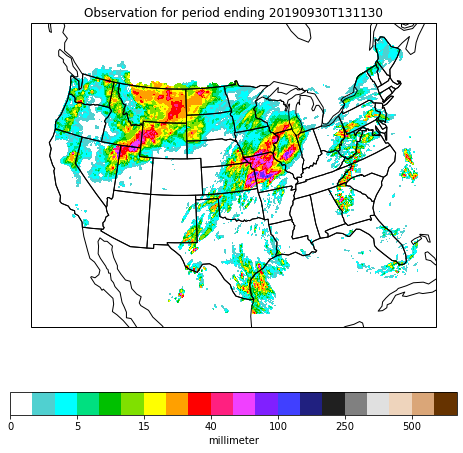

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# draw coastlines, state and country boundaries, edge of map.
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cs = ax.contourf(x, y, data, clevs, cmap=cmap, norm=norm)

# add colorbar.
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label(data.units)

ax.set_title(prcpvar.long_name + ' for period ending ' + nc.creation_time)
plt.show()